In [ ]:
import pandas as pd
from datasets import Dataset
from transformers import BartTokenizer, BartForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch

# Load the dataset
data_path = 'Generated dataset/cifar10_full_descriptions.json'
df = pd.read_json(data_path, lines=True)

# Prepare the dataset for training
# Concatenate BEiT and BLIP descriptions into a single text input
df['input_text'] = df['beit_description'] + " " + df['blip_description']

# Map labels to integers
label2id = {label: i for i, label in enumerate(df['true_label'].unique())}
df['label'] = df['true_label'].map(label2id)

# Create a Dataset object
dataset = Dataset.from_pandas(df)

# Load the tokenizer and model
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')  # Using a smaller BART model
model = BartForSequenceClassification.from_pretrained('facebook/bart-base', num_labels=10)

# Enable gradient checkpointing to save memory
model.gradient_checkpointing_enable()

# Tokenize the dataset with dynamic padding
def tokenize_function(examples):
    return tokenizer(examples['input_text'], truncation=True, padding=True, max_length=128)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Split the dataset into train and validation sets
train_dataset = tokenized_dataset.shuffle(seed=42).select(range(50000))  # 50,000 samples for training
test_dataset = tokenized_dataset.shuffle(seed=42).select(range(50000, 60000))  # 10,000 samples for test

# Set the format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Define the compute_metrics function to evaluate accuracy
def compute_metrics(p):
    logits = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = logits.argmax(-1)
    labels = p.label_ids
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# Define the training arguments with further optimizations
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=2,               # Limit the number of saved checkpoints
    load_best_model_at_end=True,      # Load the best model at the end
    num_train_epochs=10,              # Increase epochs to allow early stopping to take effect
    per_device_train_batch_size=1,    # Further reduced batch size
    per_device_eval_batch_size=1,     # Further reduced batch size for evaluation
    gradient_accumulation_steps=16,   # Accumulate gradients over 16 steps
    fp16=True,                        # Enable mixed precision training
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    dataloader_num_workers=2,         # Adjust workers for efficiency
    metric_for_best_model='accuracy', # Use accuracy to determine best model
)

# Initialize the Trainer with Early Stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Early stopping after 3 epochs with no improvement
)

# Train the model
trainer.train()

# Evaluate the model on the evaluation dataset
test_rsults = trainer.evaluate()
print(f"Evaluation Results: {test_rsults}")

# Save the fine-tuned model and tokenizer
model.save_pretrained('./fine_tuned_bart_cifar10')
tokenizer.save_pretrained('./fine_tuned_bart_cifar10')

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1', '2': 'LABEL_2', '3': 'LABEL_3', '4': 'LABEL_4', '5': 'LABEL_5', '6': 'LABEL_6', '7': 'LABEL_7', '8': 'LABEL_8', '9': 'LABEL_9'}. The number of labels wil be overwritten to 10.
Evaluating: 100%|██████████| 10000/10000 [01:09<00:00, 143.46it/s]


Accuracy: 99.73%
Precision: 99.73%
Recall: 99.73%
F1 Score: 99.73%


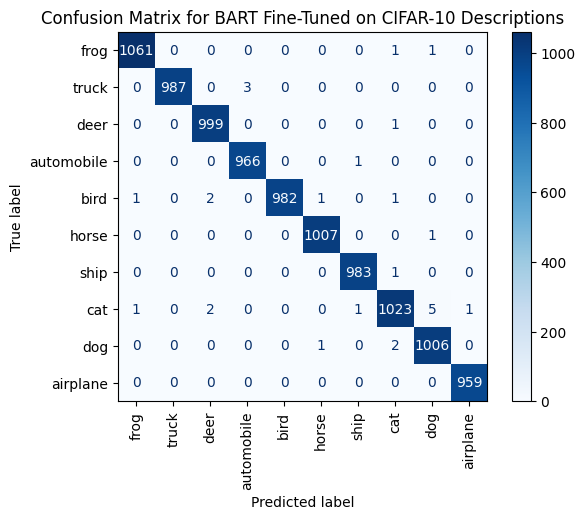

: 

In [ ]:
from transformers import BartTokenizer, BartForSequenceClassification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

# Load the fine-tuned model and tokenizer
model = BartForSequenceClassification.from_pretrained('./fine_tuned_bart_cifar10')
tokenizer = BartTokenizer.from_pretrained('./fine_tuned_bart_cifar10')

# Ensure the model is in evaluation mode
model.eval()

# Load the validation dataset again
eval_dataset = tokenized_dataset.shuffle(seed=42).select(range(50000, 60000))  # 10,000 samples for evaluation
eval_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Create DataLoader for the evaluation dataset
from torch.utils.data import DataLoader

eval_loader = DataLoader(eval_dataset, batch_size=1)  # Batch size 1 to match the fine-tuning

# Move model to the device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Collect predictions and true labels
all_preds = []
all_labels = []

# Evaluate with tqdm for progress tracking
with torch.no_grad():
    for batch in tqdm(eval_loader, desc="Evaluating"):
        inputs = {key: value.to(device) for key, value in batch.items() if key in ['input_ids', 'attention_mask']}
        labels = batch['label'].to(device)
        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=-1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Calculate evaluation metrics
accuracy = accuracy_score(all_labels, all_preds) * 100
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
precision *= 100
recall *= 100
f1 *= 100

# Print evaluation metrics in percentages
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1 Score: {f1:.2f}%")

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=list(label2id.keys()))
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix for BART Fine-Tuned on CIFAR-10 Descriptions')
plt.show()
